In [16]:
# import necessary libraries
import os, sys, glob
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm
from PIL import Image

# custom imports
# sys.path.append('../../')
# from modules.utils.GetLowestGPU import GetLowestGPU
# device = torch.device(GetLowestGPU(verbose=2))

# 1) Data Loading

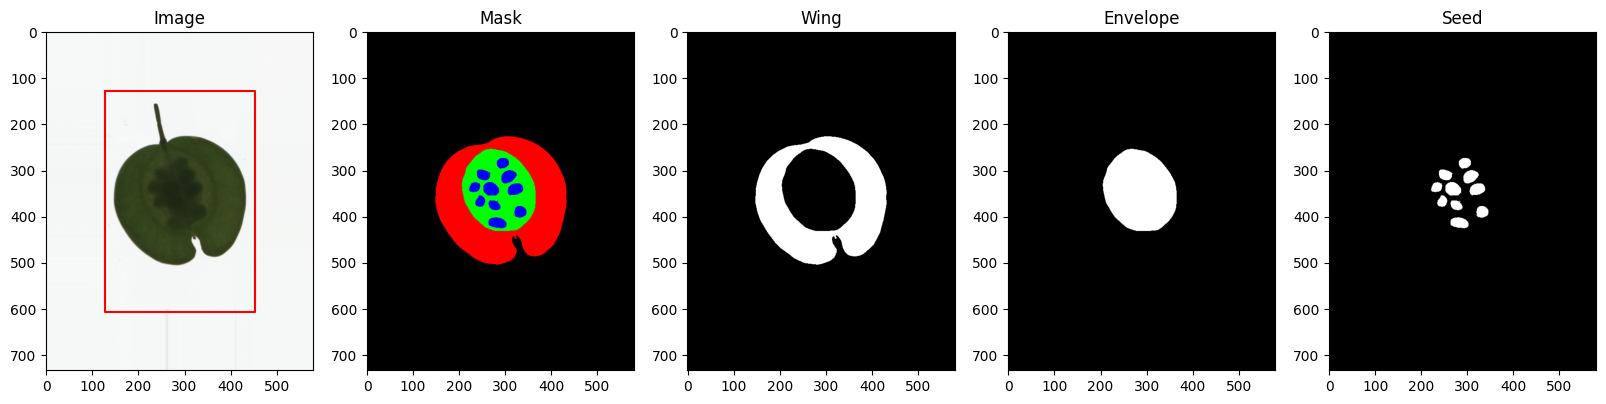

In [17]:
# define options
img_path = '../phenotyping/pennycress_pods/images_by_pod/'
mask_path = '../phenotyping/pennycress_pods/masks_by_pod/'
n_pad = 128

# load images and masks into list
mask_names = sorted([os.path.basename(x) for x in glob.glob(mask_path + '*.png')])

pennycress_images = []
pennycress_masks = []

for img_name in mask_names:
    # load image
    image = np.array(Image.open(img_path + img_name))
    image = (image[:, :, :3] / 255.0) # normalize image
    image = np.pad(image, ((n_pad, n_pad), (n_pad, n_pad), (0, 0)), 'edge') # pad image w/ values on edge
    pennycress_images.append(image)

    # load mask
    mask = np.array(Image.open(mask_path + img_name))
    mask = (mask / 255.0) # normalize mask
    mask = np.pad(mask, ((n_pad, n_pad), (n_pad, n_pad), (0, 0)), 'constant', constant_values=0) # pad mask w/ constant 0 value
    pennycress_masks.append(mask)

# split masks into wing and pod and seed
wings = [m[:, :, 0] > 0.5 for m in pennycress_masks] # take red channel and booleanize
envelopes = [m[:, :, 1:].sum(-1) > 0.5 for m in pennycress_masks] # "... blue ..."
seeds = [m[:, :, 2] > 0.5 for m in pennycress_masks] # "... green ..."

# create list for multiclass masks
multiclass_masks = []

# add additional channel to pennycress masks for one-hot encoding
for mask in pennycress_masks:
    bg = mask.sum(-1) == 0 # booleanize background
    mask = np.concatenate([bg.reshape(*bg.shape, 1), mask], axis=-1) # add background channel
    multiclass_masks.append(mask)

# plot images and masks
i = np.random.randint(0, len(pennycress_images)) #select random from list of pennycress images
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].imshow(pennycress_images[i]); ax[0].set_title('Image')
# plot line around padding
ax[0].plot([n_pad, n_pad, pennycress_images[i].shape[1] - n_pad, pennycress_images[i].shape[1] - n_pad, n_pad],
           [n_pad, pennycress_images[i].shape[0] - n_pad, pennycress_images[i].shape[0] - n_pad, n_pad, n_pad], 'r')
ax[1].imshow(pennycress_masks[i]); ax[1].set_title('Mask')
ax[2].imshow(wings[i], cmap='gray'); ax[2].set_title('Wing')
ax[3].imshow(envelopes[i], cmap='gray'); ax[3].set_title('Envelope')
ax[4].imshow(seeds[i], cmap='gray'); ax[4].set_title('Seed')
plt.show()

# 2) Data Generation

In [18]:
#import dataset class
from torch.utils.data import Dataset
import albumentations as A

# define tilegenerator class, inheriting from dataset class
class TileGenerator(Dataset):
    
    def __init__(self,
                images,
                masks,
                tile_size,
                split, #split is a string specifying 'train' or 'val'
                ):
        #init attrs/methods from dataset class w/ super()
        super().__init__()
        self.images = images
        self.masks = masks
        self.tile_size = tile_size
        self.split = split
        self.width = tile_size//2

        # extract image/row/col indices from mask pixels
        self.indices = [] #list pixel indices we want to extract tiles from
        for i, m in enumerate(masks): #enumerate to get mask index and mask values
            row_col_ixs = np.argwhere(m[n_pad:-n_pad, n_pad:-n_pad] >= 0) + n_pad #return array containing indices w/ all values inside padding
            img_ixs = i * np.ones(len(row_col_ixs), dtype=np.int32) #return image number repeated for however many indices we found
            self.indices.append(np.concatenate([img_ixs[:, None], row_col_ixs], axis=1)) # create array of image number, row, col indices
        self.indices = np.concatenate(self.indices, axis=0) # concatenate all image index arrays into one

        # make an augmenataion pipeline
        self.augment = A.Compose([
            A.Affine(rotate=[-180, 180],
                     mode=0,
                     p=1),
            A.Blur(blur_limit=7, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Transpose(p=0.5)
            ], p=1)
        
    def __len__(self): # length is the total number of tiles
        return len(self.indices) # number of tiles is equal to number of indices
    
    def __getitem__(self, index):

        i, r, c, _ = self.indices[index]
        w = int((2*self.width**2)**0.5)+1 #use pythagorean theorem to grab a slightly larger tile
        tile = self.images[i][r-w:r+w, c-w:c+w]
        mask = self.masks[i][r-w:r+w, c-w:c+w]

        # augment image and mask
        if self.split == 'train':
            tile = (255*tile).astype(np.uint8)
            mask = mask.astype(np.uint8)
            augmented = self.augment(image=tile, mask=mask)
            tile = (augmented['image'] / 255.0).astype(np.float32)
            mask = augmented['mask'].astype(np.float32)
        
        #zoom into final size of width x width
        cent = tile.shape[0]//2
        tile = tile[cent-self.width:cent+self.width, cent-self.width:cent+self.width]
        mask = mask[cent-self.width:cent+self.width, cent-self.width:cent+self.width]
        
        #convert to torch tensor
        tile = torch.from_numpy(tile.transpose(2, 0, 1)) #convert to torch tensor and transpose to channels first
        mask = torch.from_numpy(mask.transpose(2, 0, 1)) #convert to torch tensor and transpose to channels first

        # convert to float
        tile, mask = tile.float(), mask.float()

        return tile, mask

In [19]:
# options
images = pennycress_images
masks = multiclass_masks
tile_size = 128
train_prop = 0.8

#create train/val splits by image
p = np.random.permutation(len(images))
train_idx = p[:int(train_prop*len(images))]
val_idx = p[int(train_prop*len(images)):]



# instantiate tilegenerator class
train_generator = TileGenerator(
    images=[images[i] for i in train_idx],
    masks=[masks[i] for i in train_idx], 
    tile_size=tile_size, 
    split='train')

val_generator = TileGenerator(
    images=[images[i] for i in val_idx],
    masks=[masks[i] for i in val_idx], 
    tile_size=tile_size, 
    split='val')

Plotting training examples...


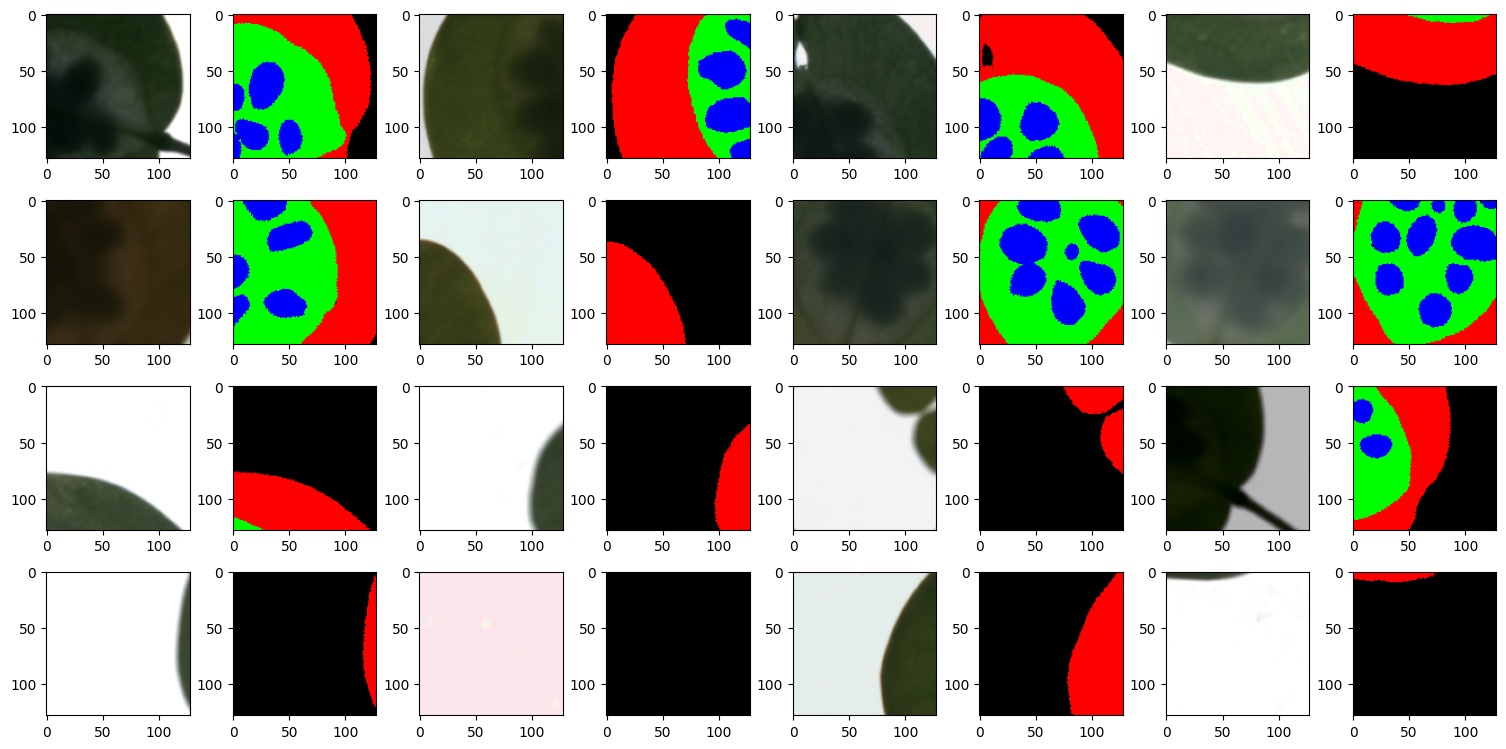

Plotting validation examples...


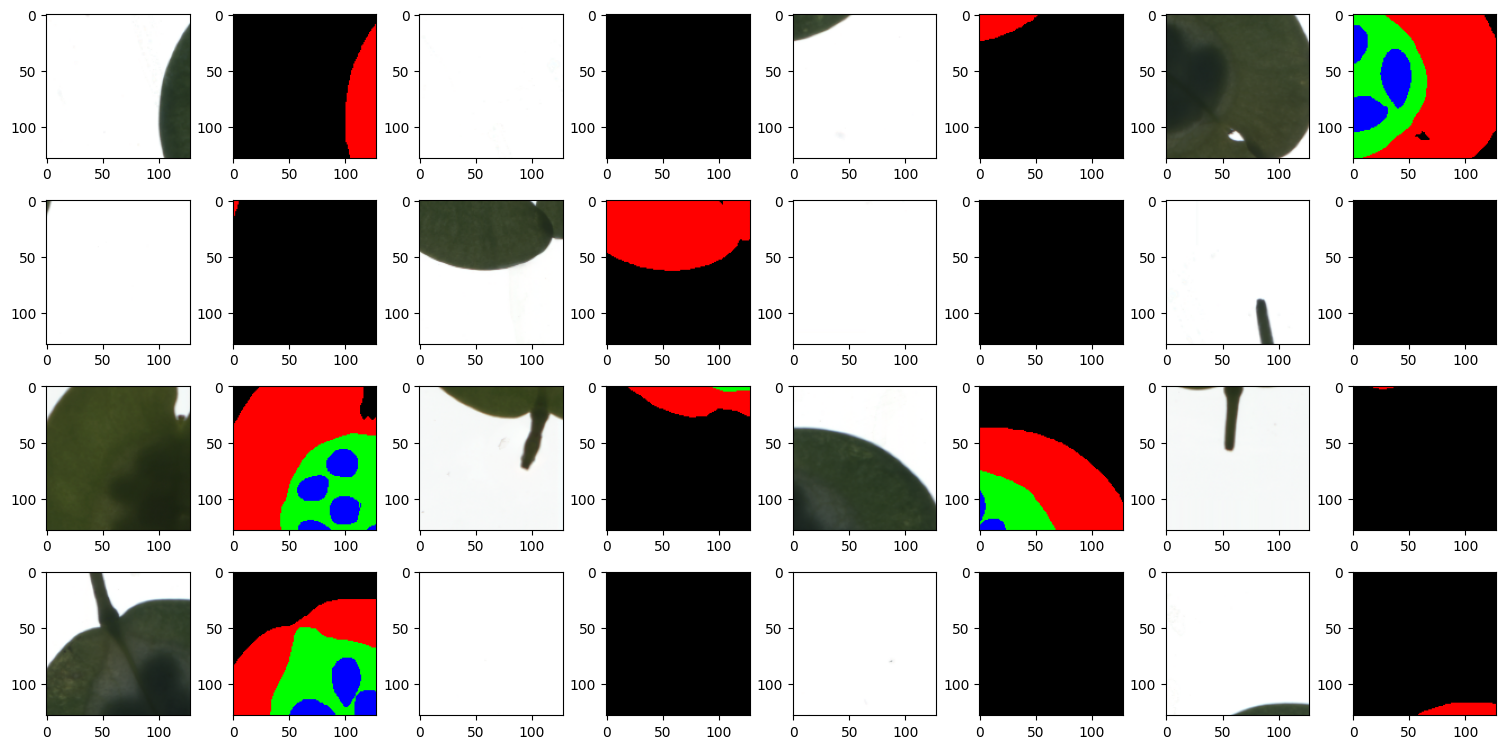

In [20]:
#plot random samples
figsize = 15
np.random.seed(0)
    
print('Plotting training examples...')
fig = plt.figure(figsize=(figsize, figsize/2))
N = len(train_generator)
for i in range(16):
    rand_idx = np.random.choice(N)
    img, msk = train_generator[rand_idx]
    img = img.permute(1, 2, 0).numpy()
    msk = msk.permute(1, 2, 0).numpy()[:, :, 1:]
    ax = fig.add_subplot(4, 8, 2*i+1)
    plt.imshow(img, vmin=0, vmax=1, cmap='gray')
    ax = fig.add_subplot(4, 8, 2*i+2)
    plt.imshow(msk, vmin=0, vmax=1, cmap='gray')
plt.tight_layout(pad=0.5)
plt.show()

print('Plotting validation examples...')
fig = plt.figure(figsize=(figsize, figsize/2))
N = len(val_generator)
for i in range(16):
    rand_idx = np.random.choice(N)
    img, msk = val_generator[rand_idx]
    img = img.permute(1, 2, 0).numpy()
    msk = msk.permute(1, 2, 0).numpy()[:, :, 1:]
    ax = fig.add_subplot(4, 8, 2*i+1)
    plt.imshow(img, vmin=0, vmax=1)
    ax = fig.add_subplot(4, 8, 2*i+2)
    plt.imshow(msk, vmin=0, vmax=1)
plt.tight_layout(pad=0.5)
plt.show()

# Build U-Net

In [21]:
# create U-Net class inheriting from torch.nn.Module
class UNet(torch.nn.Module):

    def __init__(self,
                enc_layer_sizes = [16, 32, 64, 128],
                dec_layer_sizes = [128, 64, 32, 16],
                in_channels=3,
                out_channels=4,
                dropout_rate=0.1,
                conv_per_block=1):

        super().__init__() #inherit attrs. from Module

        self.enc_layer_sizes = enc_layer_sizes
        self.dec_layer_sizes = dec_layer_sizes
        self.num_enc_layers = len(enc_layer_sizes)
        self.num_dec_layers = len(dec_layer_sizes)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = 3
        self.padding = 1
        self.dropout_rate=dropout_rate
        self.conv_per_block=conv_per_block

        # create lists to hold each layer group
        self.enc_layers = torch.nn.ModuleList()
        self.bottleneck_layers = torch.nn.ModuleList()
        self.dec_layers = torch.nn.ModuleList()

        # create encoder blocks
        for i in range(self.num_enc_layers-1):
            if i == 0:
                self.enc_layers += self.enc_layer(self.in_channels, self.enc_layer_sizes[i], self.kernel_size, self.padding)
            else:
                self.enc_layers += self.enc_layer(self.enc_layer_sizes[i-1], self.enc_layer_sizes[i], self.kernel_size, self.padding)

        # create bottleneck block        
        self.bottleneck_layers += self.enc_layer(self.enc_layer_sizes[-2], self.enc_layer_sizes[-1], self.kernel_size, self.padding, pool=False)

        # create decoder blocks
        for i in range((self.num_dec_layers-1)):
            self.dec_layers += self.dec_layer(self.dec_layer_sizes[i], self.dec_layer_sizes[i+1], self.kernel_size, self.padding)

        # add final layer
        self.final_layer = torch.nn.Conv2d(self.dec_layer_sizes[-1], out_channels, kernel_size=1, padding=0)
        self.final_activation = torch.nn.Softmax(dim=1)


    def conv_block(self, in_channels, out_channels, kernel_size, padding):
        
        conv_block = torch.nn.Sequential()
        for i in range(self.conv_per_block):

            if i == 0:
                conv_block += torch.nn.Sequential(torch.nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=self.kernel_size,
                    padding=self.padding),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.LeakyReLU(),
                torch.nn.Dropout2d(self.dropout_rate)
                )
            else:
                # define base conv_block structure
                conv_block += torch.nn.Sequential(
                    torch.nn.Conv2d(
                        in_channels=out_channels,
                        out_channels=out_channels,
                        kernel_size=self.kernel_size,
                        padding=self.padding),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.LeakyReLU(),
                    torch.nn.Dropout2d(self.dropout_rate)
                )
        return conv_block
    
    def enc_layer(self, in_channels, out_channels, kernel_size, padding, pool=True):

        # define encoder layer structure
        enc_layer = self.conv_block(in_channels,
                                    out_channels,
                                    kernel_size=self.kernel_size, 
                                    padding=self.padding)
        if pool == True:
            enc_layer.append(torch.nn.MaxPool2d(2))

        return enc_layer

    def dec_layer(self, in_channels, out_channels, kernel_size, padding, upsample=True):

        # define decoder layer structure
        if upsample == True:
            upsample = torch.nn.Sequential(
                torch.nn.Upsample(scale_factor=2, mode='nearest'),
                torch.nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=self.kernel_size,
                    padding=self.padding)
            )
            #prepend upsampling layer to conv_block to make decoder
            dec_layer = upsample + self.conv_block(in_channels, 
                                                    out_channels, 
                                                    self.kernel_size, 
                                                    self.padding)

        else:
            dec_layer = self.conv_block(in_channels, out_channels, self.kernel_size, self.padding)

        return dec_layer


    # define forward pass
    def forward(self, x):
        
        cache = []
        #propagate through encoder layers
        for i, enc_layer in enumerate(self.enc_layers):
            x = enc_layer(x)
            if (i+1) % 5 == 4: #5 layers per encoder block; on the 4th layer, save output in cache
                cache.append(x) #save layer outputs in cache for skip connections

        #propagate through bottleneck layer
        for bottleneck_layer in self.bottleneck_layers:
            x = bottleneck_layer(x)

        #propagate through decoder layers
        j = 0 # set index control var for cache
        for i, dec_layer in enumerate(self.dec_layers):
            x = dec_layer(x)
            if (i+1) % 6 == 2: # 6 layers per decoder block; on the 2nd layer, concatenate with cache
                x = torch.cat([x, cache[-(j+1)]], dim=1)
                j += 1

        #apply final conv layer
        x = self.final_layer(x)
        x = self.final_activation(x)
        return x

# Notes 
- important to control the *number of channels per layer*, so maybe don't hardcode with doubling 
    - possible solution: define layers with a list, and *len(list)* is num_layers **done**
- be wary of dropout; it can easily wreck model w/ wrong value, so parameterize **done**
- you can hardcode kernel size and padding **done**
- you may want multiple conv layers between padding and down/upsamples, so parameterize this as well


In [22]:
unet = UNet(enc_layer_sizes=[16, 32, 64, 128],
            dec_layer_sizes=[128, 64, 32, 16],
            in_channels=3,
            out_channels=4,
            conv_per_block=1)
unet
print(unet)

# x, y = train_generator[0]
# x = x.unsqueeze(0).to(device)
# x_pred = unet(x)
# print(x.shape, x_pred.shape)



UNet(
  (enc_layers): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout2d(p=0.1, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Dropout2d(p=0.1, inplace=False)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

In [23]:
print(unet)

UNet(
  (enc_layers): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout2d(p=0.1, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Dropout2d(p=0.1, inplace=False)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

# Implement the Backward Pass/Training

In [24]:
# define get_batch function 
from torch.utils.data import DataLoader

# set some options
batch_size = 32
num_workers = 0

# generate random stack of input/output tiles and return as batch

def get_batch(split):
    if split == 'train':
        generator = train_generator
    if split == 'val':
        generator = val_generator
    
    #instantiate loader
    loader = DataLoader(dataset=generator,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        shuffle=True)

    # load batch on cpu
    xb, yb = next(iter(loader))
    return xb, yb

In [25]:
xb, yb = get_batch('train')

In [26]:
xb.shape, yb.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32, 4, 128, 128]))

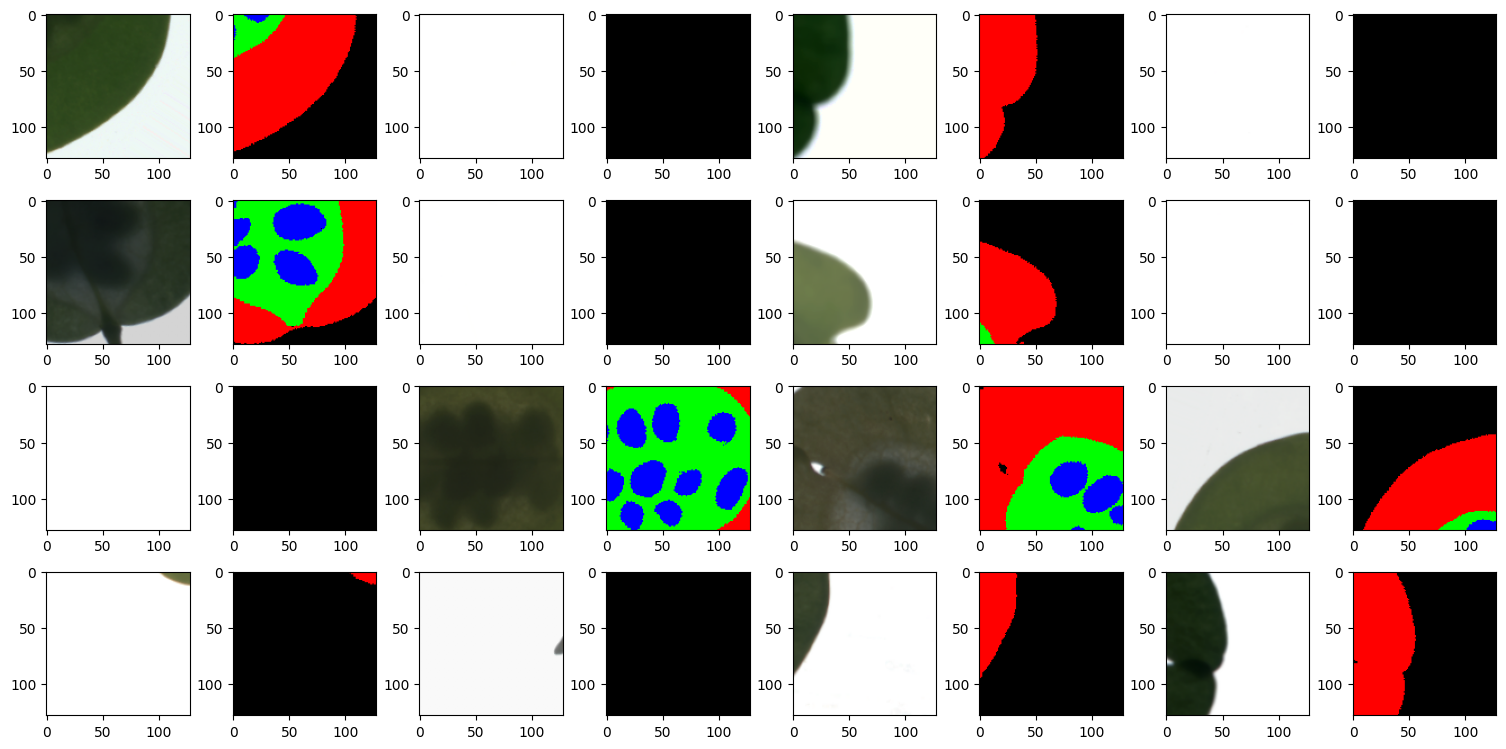

In [27]:
#plot random samples
figsize = 15
np.random.seed(0)

fig = plt.figure(figsize=(figsize, figsize/2))
for i in range(16):
    img, msk = xb[i].detach().cpu(), yb[i].detach().cpu()
    img = img.permute(1, 2, 0).numpy()
    msk = msk.permute(1, 2, 0).numpy()[:, :, 1:]
    ax = fig.add_subplot(4, 8, 2*i+1)
    plt.imshow(img, vmin=0, vmax=1, cmap='gray')
    ax = fig.add_subplot(4, 8, 2*i+2)
    plt.imshow(msk, vmin=0, vmax=1, cmap='gray')
plt.tight_layout(pad=0.5)
plt.show()

In [28]:
# define our loss function, optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)

In [29]:
# define estimate_loss function

# options
batches_per_eval = 10

# generate random batches from the validation set and average the error to measure current validation loss
@torch.no_grad() # no gradients will be computed; we don't want to update, just quickly evaluate
def estimate_loss():
    unet.eval() # set model to evaluation mode; no dropout, batch_norm, etc.

    # initialize loss
    train_loss, val_loss = 0, 0

    for _ in range(batches_per_eval):
        # batch loss for train
        xb, yb = get_batch('train')
        train_loss += loss_function(unet(xb), yb).item()

        # batch loss for val
        xb, yb = get_batch('val')
        val_loss += loss_function(unet(xb), yb).item()
    
    # average the loss
    train_loss /= batches_per_eval
    val_loss /= batches_per_eval

    unet.train() # re-enable training

    return train_loss, val_loss

In [30]:
estimate_loss()

(1.3824334025382996, 1.381961178779602)

In [ ]:
# training loop
import time

# options 
max_iters = 100000 # maximum number of iterations
log_interval = 1 # iterations between logging batch statistics
eval_interval = 100 # checkpointing interval
log_path = '../phenotyping/pennycress/multiclass_training/log.csv'
chckpnt_path = '../phenotyping/pennycress/weights/checkpoint_{0}.pt'
iter_update = 'step {0}: train loss {1:.4e}, val loss {2:.4e}\r'

# more options
best_val_loss = None # initialize best validation loss
early_stop = 10 # set value for early stopping counter
t0 = time.time() # start timer
last_improved = 0 # start early stopping counter

# training loop
for iter_num in range(max_iters+1): # loop over iterations (not epochs)

    # during the first iteration, create a log file for book keeping
    if iter_num == 0:
        with open(log_path, 'w') as f: 
            f.write('iter,train_loss,val_loss\n')

    #
    # checkpointing and book keeping
    #

    # at each eval_interval, estimate the loss and checkpoint the model
    if iter_num % eval_interval == 0:

        # estimate loss
        train_loss, val_loss = estimate_loss()

        # update user
        print(iter_update.format(iter_num, train_loss, val_loss)) 

        # update log
        with open(log_path, 'a') as f: 
            f.write(f'{iter_num},{train_loss},{val_loss}\n')

        # checkpoint model (store model, optimizer, metadata, etc.)
        if iter_num > 0:
            checkpoint = {
                'model': unet.state_dict(),
                'optimizer': optimizer.state_dict(),
                'iter_num': iter_num,
                'best_val_loss': best_val_loss,
                'train_ids': train_idx,
                'val_ids': val_idx,
            }
            torch.save(checkpoint, chckpnt_path.format(iter_num))

            
        
        # update best val loss if it improved
        if best_val_loss is None:
            best_val_loss = val_loss
            
        if val_loss < best_val_loss:
            # update best validation loss
            best_val_loss = val_loss

            # reset early stopping counter
            last_improved = 0

            # update user if validation loss improved
            print(f'*** validation loss improved: {best_val_loss:.4e} ***')

        # if validation loss did not improve, increment early stopping counter
        else:
            last_improved += 1
            print(f'validation has not improved in {last_improved} steps')

        # if early stopping counter exceeds early_stop, stop training
        if last_improved > early_stop:
            print()
            print(f'*** no improvement for {early_stop} steps, stopping ***')
            break

    #
    # model update with gradient descent
    #

    # generate a batch of training data
    xb, yb = get_batch('train')

    # compute the loss
    loss = loss_function(unet(xb), yb)

    # kill training if loss is NaN
    if torch.isnan(loss):
        print('loss is NaN, stopping')
        break

    # compute gradients
    loss.backward()

    # update weights
    optimizer.step()

    # zero gradients
    optimizer.zero_grad(set_to_none=True)

    # evaluate timing
    t1 = time.time() # get current time
    dt = (t1 - t0) / log_interval # compute time per iteration
    t0 = t1 # reset timer

    # update user with batch statistics
    if iter_num % log_interval == 0:
        print(f'iter {iter_num}: loss {loss:.4e}, time {dt*1000:.2f}ms', end='\r')

step 0: train loss 1.3822e+00, val loss 1.3820e+00
validation has not improved in 1 steps
step 100: train loss 9.5811e-01, val loss 9.2777e-01
*** validation loss improved: 9.2777e-01 ***


: 

: 

# Plot Input / Prediction Pairs on Val. Images

In [ ]:
# options
num_plot = 32

# get batch from val set for plotting
xb, yb = get_batch('val')

# make prediction with unet
yb_pred = unet(xb)

# convert to cpu, numpy, and change channels for visualization
xb_numpy = xb.detach().cpu().permute(0, 2, 3, 1).numpy()
yb_numpy = yb.detach().cpu().permute(0, 2, 3, 1).numpy()[:, :, :, 1:]
yb_pred_numpy = yb_pred.detach().cpu().permute(0, 2, 3, 1).numpy()

# convert predicted probabilities to predicted classes and retain four channels
yb_pred_numpy = np.argmax(yb_pred_numpy, axis=3)
preds = np.zeros(yb_pred_numpy.shape + (4,))
for i in range(4):
    preds[:, :, :, i] = yb_pred_numpy == i
yb_pred_numpy = preds[:, : , :, 1:]

# yb_pred_numpy = np.concatenate([yb_pred_numpy[:, :, :, None] == i for i in range(4)], axis = 3).astype(int)
# yb_pred_numpy = yb_pred_numpy[:, :, :, 1:]

# plot images and masks
for i in range(num_plot):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    ax[0].imshow(xb_numpy[i]); ax[0].set_title('Input')
    ax[1].imshow(yb_numpy[i]); ax[1].set_title('Target')
    ax[2].imshow(yb_pred_numpy[i]); ax[2].set_title('Prediction')
    plt.show()


NameError: name 'get_batch' is not defined

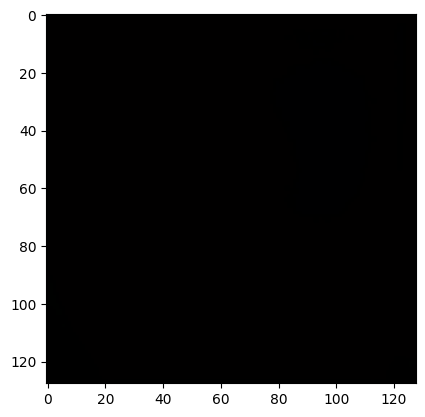

In [ ]:
plt.imshow(yb_pred_numpy[0, :, :, :])